# 最小覆盖圆与最大空圆

对于平面上一群给定的点，覆盖所点的最小圆称为最小覆盖圆，以及圆心在点的凸包区域之内，并且圆内没有任何点的最大圆。

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
import matplotlib

## 最小覆盖圆

首先需要找到这群点的凸包，所谓凸包是指N维空间中的一个区域，该区域中任意两点之间的线段都完全被包含在该区域之中，二维平面上的凸多边形就是典型的凸包。然后只需找到覆盖凸包的最小圆即可。最小圆有两种情况：

* 以凸包上的两点为直径的圆
* 过凸包上三点的圆

要找到通过凸包上两点的圆，就需要找到凸包上的一对距离最远的点。该算法成为旋转卡壳算法(Rotating calipers)。下面是从[code.activestate.com](http://code.activestate.com/recipes/117225-convex-hull-and-diameter-of-2d-point-sets/)上找到的实现程序。

其中`hulls(Points)`可以找到`Points`的凸包，它返回两个列表`U`和`L`分别表示凸包的上半部分和下半部分。凸包的这两个部分由X轴坐标的最小点和最大点切分。`rotatingCalipers(U, L)`的参数是凸包的上半部分和下半部分，它返回一对卡壳(平行线)夹住凸包时所通过的点对。如下图所示：

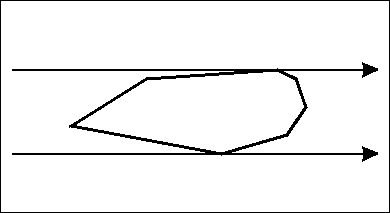

http://code.activestate.com/recipes/117225-convex-hull-and-diameter-of-2d-point-sets/

In [7]:
def orientation(p,q,r):
    '''Return positive if p-q-r are clockwise, neg if ccw, zero if colinear.'''
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])

def hulls(Points):
    '''Graham scan to find upper and lower convex hulls of a set of 2d points.'''
    U = []
    L = []
    Points.sort()
    for p in Points:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U, L

def rotatingCalipers(U, L):
    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        
        # if all the way through one side of hull, advance the other side
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        
        # still points left on both lists, compare slopes of next hull edges
        # being careful to avoid divide-by-zero in slope calculation
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1
            
def diameter(Points):
    U, L = hulls(Points)
    diam, pair = max([((p[0]-q[0])**2 + (p[1]-q[1])**2, (p,q))
                     for p,q in rotatingCalipers(U, L)])
    return diam**0.5, pair            

下面创建随机100个点，并绘制它们的凸包以及候选的最远点对。

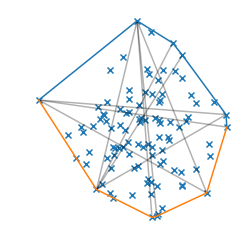

In [8]:
from matplotlib.collections import LineCollection
np.random.seed(42)
points = np.random.randn(100, 2)
u, l = hulls(points.tolist())
ua, la = map(np.array, [u, l])

fig, ax = pl.subplots()
ax.set_aspect(True)
ax.scatter(*points.T, marker="x")
ax.plot(ua[:, 0], ua[:, 1])
ax.plot(la[:, 0], la[:, 1])

lines = [[p1, p2] for p1, p2 in rotatingCalipers(u, l)]
lc = LineCollection(lines, colors="black", alpha=0.3)
ax.add_collection(lc)
ax.axis("off");

SciPy中提供了计算凸包的类：`scipy.spatial.ConvexHull()`。它的`vertices`属性保存凸包上点的序号。为了调用`rotatingCalipers()`，下面的`convex_hull_ul()`把凸包分为上半部分和下半部分。`min_2points_circle()`找到凸包上以两点为直径的最大的圆：

In [9]:
from scipy import spatial

def convex_hull_ul(points):
    hull = spatial.ConvexHull(points)
    verts = hull.vertices
    verts = np.roll(verts, -np.argmin(points[verts, 0]))
    sep = np.argmax(points[verts, 0])
    verts_l, verts_u = verts[:sep+1], np.r_[verts[sep:], verts[0]]
    return points[verts_u[::-1]], points[verts_l]

def min_2points_circle(points):
    d, (p1, p2) = diameter(points.tolist())
    return ((p1[0] + p2[0]) * 0.5, (p1[1] + p2[1]) * 0.5), d * 0.5

由下面的结果可知，不存在以两点为直径覆盖所有点的圆。

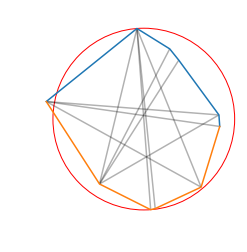

In [10]:
fig, ax = pl.subplots()
ax.set_aspect(True)
u, l = convex_hull_ul(points)
pl.plot(*u.T)
pl.plot(*l.T)
lines = [[p1, p2] for p1, p2 in rotatingCalipers(u.tolist(), l.tolist())]
lc = LineCollection(lines, colors="black", alpha=0.3)
center, r = min_2points_circle(points)
circle = pl.Circle(center, r, fill=False, color="red")
ax.add_collection(lc)
ax.add_artist(circle)
ax.margins(0.1)
ax.axis("off");

经过凸包上3点的圆可以使用最远点沃罗诺伊图计算。最远点沃罗诺伊图(Voronoi Diagram)是一种空间分割算法，它根据指定的N个胞点将空间分割为N个区域，每个区域中的所有坐标点都与该区域对应的胞点最远。

`scipy.spatial.Voronoi()`计算沃罗诺伊图，当`furthest_site`参数为`True`时计算最远点沃罗诺伊图。下面计算以`points`为胞点的最远点沃罗诺伊图，并显示构成各个区域的顶点(`vertices`)。

In [11]:
from scipy.spatial.distance import cdist

v = spatial.Voronoi(points, furthest_site=True)
v.vertices

array([[ -0.20575692,   0.43850165],
       [ -0.27182   ,   0.31900039],
       [ -0.67411529,   1.4868452 ],
       [  1.12081868,   1.7188199 ],
       [ -2.06130037,  -1.11719394],
       [ -0.81533748,   0.14063779],
       [ -0.75162019,   0.12491028],
       [-18.97493062, -13.71817857]])

下面遍历`v.point_region`找到与每个胞点对应的区域，然后遍历区域找到构成每个区域的顶点。将与顶点对应的胞点添加进`vertice_points`字典中。胞点与顶点之间的相关信息也可以通过`v.ridge_dict`获得。

In [12]:
def calc_vertice_points_map(v):
    from collections import defaultdict

    vertice_points = defaultdict(list)

    for point_id, region_id in enumerate(v.point_region):
        region = v.regions[region_id]
        if region:
            for vertice_id in region:
                if vertice_id != -1:
                    vertice_points[vertice_id].append(point_id)
    return vertice_points

vertice_points = calc_vertice_points_map(v)
vertice_points

defaultdict(list,
            {0: [37, 39, 61],
             1: [37, 61, 89],
             2: [18, 39, 61],
             3: [37, 39, 73],
             4: [62, 78, 89],
             5: [53, 61, 78],
             6: [61, 78, 89],
             7: [62, 78, 83]})

对于每个顶点找到与之最远的胞点距离，然后找到所有顶点中该距离最小的顶点。该顶点就是最小覆盖原圆的圆心，而该距离就是最小圆的半径。

In [13]:
def distance(vid, pids):
    return np.max(np.sum((v.vertices[vid] - v.points[pids])**2, axis=-1)**0.5)

min((distance(vid, pid), v.vertices[vid]) for vid, pid in vertice_points.items())

(2.4011794636311912, array([-0.27182   ,  0.31900039]))

下面是完整的函数：

In [16]:
def min_3points_circle(points):
    v = spatial.Voronoi(points, furthest_site=True)   
    vertice_points = calc_vertice_points_map(v)
                    
    def distance(vid, pids):
        return np.max(np.sum((v.vertices[vid] - v.points[pids])**2, axis=-1)**0.5)

    r, center = min((distance(vid, pid), v.vertices[vid]) for vid, pid in vertice_points.items())
    return center, r

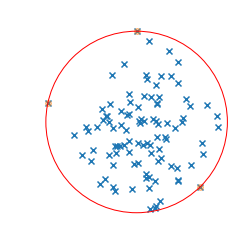

In [17]:
fig, ax = pl.subplots()
ax.set_aspect(True)
ax.scatter(*points.T, marker="x")
center, radius = min_3points_circle(points)
circle = pl.Circle(center, radius, fill=False, color="red")
ax.add_artist(circle)
circle_points = points[(radius - np.sum((points - center)**2, axis=1)**0.5) < 1e-12]
ax.scatter(*circle_points.T, marker="o", alpha=0.4)
ax.autoscale_view()
ax.margins(0.1)
ax.axis("off");

## 最大空圆

使用最近点沃罗诺伊图可以解决最大空圆问题：找到一个半径最大的圆，使得其圆心在一组点的凸包区域之内，并且圆内没有任何点。最大空圆是以为顶点圆心，以与之最近的胞点的距离为半径的圆中的某一个。

下面是计算最大空圆的程序。程序中用`pylab.Polygon.contains_point()`判断用`ConvexHull`计算的凸包多边形是否包含`vertices`中的点，用以剔除掉圆心在凸包之外的圆。

`vertice_points`是一个字典，它的键为顶点的下标，值为与其最近的胞点的下标。注意这里剔除掉了所有在凸包之外的`vertices`点。最后对于`vertice_points`中的每一对点，找到距离最大的那对点，即可得出圆心坐标和圆的半径。

r =  0.174278456762 , center =  [ 0.46973363  0.59356531]


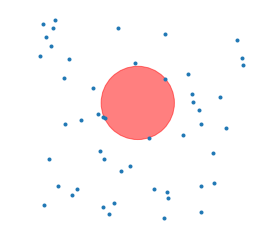

In [20]:
n = 50
np.random.seed(42)
points2d = np.random.rand(n, 2)
vo = spatial.Voronoi(points2d)
ch = spatial.ConvexHull(points2d)
poly = pl.Polygon(points2d[ch.vertices])
vs = vo.vertices

vertice_points = {k:v for k, v in calc_vertice_points_map(vo).items() if poly.contains_point(vs[k])}

def dist(p1, p2):
    return ((p1-p2)**2).sum()**0.5

max_cicle = max((dist(points2d[pidxs[0]], vs[vidx]), vs[vidx])
                for vidx, pidxs in vertice_points.items())
r, center = max_cicle
print("r = ", r, ", center = ", center)

ax = pl.subplot(111, aspect="equal")
ax.plot(points2d[:, 0], points2d[:, 1], ".")

c = pl.Circle(center, r, fill=True, color="red", alpha=0.5)
ax.add_artist(c)
ax.axis("off");